In [3]:
!pip install ultralytics


In [4]:
pip install opencv-python-headless --user


Note: you may need to restart the kernel to use updated packages.


In [41]:
pip install ultralytics opencv-python-headless pillow

Note: you may need to restart the kernel to use updated packages.



0: 384x640 1 person, 4 cars, 1 bus, 181.2ms
Speed: 8.3ms preprocess, 181.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 bus, 1 train, 170.4ms
Speed: 2.4ms preprocess, 170.4ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 bus, 161.5ms
Speed: 3.7ms preprocess, 161.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bus, 164.3ms
Speed: 3.0ms preprocess, 164.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bus, 160.0ms
Speed: 3.1ms preprocess, 160.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 4 cars, 1 bus, 177.0ms
Speed: 2.8ms preprocess, 177.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bus, 159.1ms
Speed: 2.4ms preprocess, 159.1ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person

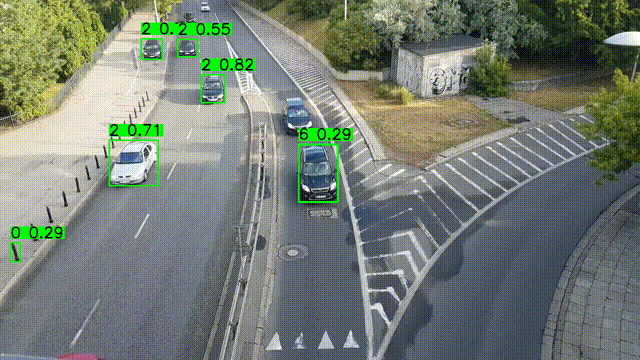

In [15]:
import os
from ultralytics import YOLO
import cv2
from IPython.display import Image, display

# Load the YOLOv8 model
model = YOLO('yolov8n.pt')

# Input video path
input_video_path = './video.mp4'
cap = cv2.VideoCapture(input_video_path)

# Check if the video was opened correctly
if not cap.isOpened():
    print(f"Error: Unable to open video '{input_video_path}'")
    exit()

# Output video path
output_dir = './runs/detect/track'
os.makedirs(output_dir, exist_ok=True)
output_video_path = os.path.join(output_dir, 'video.avi')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_video_path, fourcc, 30.0, (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

# Read frames and perform detection and tracking
frame_count = 0
max_frames = 300  # Limit frames to avoid infinite loop

while frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect objects with YOLOv8
    results = model(frame)

    # Draw results on the frame
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()  # Bounding box coordinates
        scores = result.boxes.conf.cpu().numpy()  # Confidence scores
        classes = result.boxes.cls.cpu().numpy()  # Predicted classes

        for box, score, cls in zip(boxes, scores, classes):
            x1, y1, x2, y2 = map(int, box)
            class_id = int(cls)
            label = f'{class_id} {score:.2f}'

            # Draw the detection box on the image
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Increase font size for the label text
            font_scale = 1.0
            font_thickness = 2
            font = cv2.FONT_HERSHEY_SIMPLEX
            text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
            text_x = x1
            text_y = y1 - 10

            # Ensure text stays within image boundaries
            if text_y - text_size[1] < 0:
                text_y = y1 + 10 + text_size[1]

            # Draw text background rectangle
            cv2.rectangle(frame, (text_x, text_y - text_size[1]), (text_x + text_size[0], text_y + 2), (0, 255, 0), cv2.FILLED)

            # Draw the label text on the image
            cv2.putText(frame, label, (text_x, text_y), font, font_scale, (0, 0, 0), font_thickness)

    # Write the processed frame to the output video
    out.write(frame)

    frame_count += 1

# Release the capture and close the output files
cap.release()
out.release()

# Check if the output video file exists before converting to GIF
if os.path.exists(output_video_path):
    # Convert the output video to GIF with larger scale and higher quality
    gif_output_path = os.path.join(output_dir, 'detections_high_quality.gif')
    ffmpeg_path = 'C:/Users/eyabe/Downloads/ffmpeg-master-latest-win64-gpl/bin/ffmpeg.exe'
    conversion_command = f'{ffmpeg_path} -y -i "{output_video_path}" -vf "fps=10,scale=640:-2" -b:v 2M "{gif_output_path}"'
    print(f"Running command: {conversion_command}")

    # Run ffmpeg command and capture the result
    result = os.system(conversion_command)
    
    # Check if the GIF was created successfully
    if result == 0 and os.path.exists(gif_output_path):
        # Display the GIF in the notebook
        display(Image(filename=gif_output_path))
    else:
        print(f"Error: GIF file was not created at '{gif_output_path}' or ffmpeg command failed. Check ffmpeg installation and permissions.")
else:
    print(f"Error: Output video file was not created at '{output_video_path}'")
